In [1]:
import pandas as pd
from pathlib import Path
import json
from datetime import datetime

## 1. Data import

In [2]:
data_path = Path("./data")

In [3]:
# telegram specific text with entities format
def join_message(arr) -> str:
    buffer = []
    for chunk in arr:
        if type(chunk) == str:
            buffer.append(chunk)
    return " ".join(buffer)

In [4]:
chunks = []
for file in data_path.glob("*.json"):
    data = json.loads(file.read_text())
    chunk_template = {
        "link": file.name,
        "id": data["id"],
        "name": data["name"],
    }
    for item in data["messages"]:
        if (item["type"] != "message"): continue
        if len(item.get("text")) < 5: continue
        text = item["text"]
        if type(text) == list:
            text = join_message(text)
        chunk = chunk_template | {
            "timestamp": item["date"],
            "text": text
        }
        chunks.append(chunk)

In [5]:
len(chunks)

5894

## 2. Coersions and filtering

In [6]:
df = pd.DataFrame(chunks)

In [7]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [8]:
df["timestamp"].min(), df["timestamp"].max()

(Timestamp('2019-07-13 15:54:42'), Timestamp('2022-06-12 10:56:18'))

In [9]:
start = datetime(year=2022, month=2, day=1)

In [10]:
df = df[df["timestamp"] > start].copy()

In [11]:
df["date"] = df.timestamp.apply(lambda x: x.date())

In [12]:
df.set_index("timestamp", inplace=True)

In [13]:
df

,link,id,name,text,date
timestamp,,,,,
2022-03-23 11:11:02,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...",Диди Дигоми\nТавдадебули 21\n\n \n\nНовый корп...,2022-03-23
2022-03-23 12:39:04,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...",Глдани 1й мкр\nУл. Хизабавра 3 \n\n \n\nНовый ...,2022-03-23
2022-03-23 13:29:40,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...",Глдани\nУл. Керчи 6 \n\n \n\nНовый корпус \n70...,2022-03-23
2022-03-23 13:30:04,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...",Глдани 1й мкр\nУл. Хизабавра 3 \n\n \n\nНовый ...,2022-03-23
2022-03-23 13:30:42,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...",Диди Дигоми\nТавдадебули 21\n\n \n\nНовый корп...,2022-03-23
...,...,...,...,...,...
2022-06-10 13:39:38,arendapokupkageorgia.json,1678678376,Недвижимость Грузия Аренда Тбилиси,"#939 \n\n600$\n\nКомнат 3, спален 2\nПл...",2022-06-10
2022-06-10 13:44:13,arendapokupkageorgia.json,1678678376,Недвижимость Грузия Аренда Тбилиси,#940 \n\n500$\n\nКвартира-студия\nКомн...,2022-06-10
2022-06-01 13:58:23,myflatintbilisi.json,1794574917,Аренда недвижимости Тбилиси (MyFlat),Сдаётся квартира рядом с метро Варкетили с 2 с...,2022-06-01


## 3. Parsing price

Price parsing will be performed in two steps:
1. Extract any number associated with dollar sign
2. If step 1 failed, find any round-ish number 

In [14]:
import regex as re

In [15]:
pattern = re.compile("(?<=\$?\s?)\d{3,4}(?=\s?$?)")

In [16]:
pattern.findall("dakjshd $500 dhfkj")

['500']

In [17]:
pattern_all = re.compile("\d{3,4}")

In [18]:
pattern.findall("awlabari 475 dakjshd 45 square meters 500 dolars dhfkj")

['475', '500']

In [19]:
def find_price(text) -> int:
    results = pattern.findall(text)
    if len(results) == 1:
        return int(results[0])
    elif len(results) > 1:
        # try finding maximum value
        return max([int(i) for i in results])
    
    # fallback
    results = pattern_all.findall(text)
    if len(results) == 1:
        return int(results[0])
    
    elif len(results)> 1:
        potential_results = []
        for result in reults:
            p = int(result)
            if (p % 10 == 0) and (p % 100 == 0):
                potential_results.append(p)
        return max(potential_results)
    
    return pd.NA

In [20]:
df.text.iloc[1]

'Глдани 1й мкр\nУл. Хизабавра 3 \n\n \n\nНовый корпус \n92 кв\n2 спальни \n6/7 этаж (есть лифт)\nБалкон\nДуховка  \nЦена: 1200$ \nМожно на пол года \nПри аренде на год и оплате за 3 месяца вперед цена: 1000$\nМожно всем\nПо всем вопросам пишите  '

In [21]:
df["price"] = df.text.apply(find_price)

In [22]:
df[df.price.isna()].head(30)

,link,id,name,text,date,price
timestamp,,,,,,
2022-04-03 13:46:41,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...",📈 \nОб этом в программе «Деловое утро» рас...,2022-04-03,<NA>
2022-04-19 10:01:37,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...","Друзья, сообщаем, что в период 22-25 апреля вк...",2022-04-19,<NA>
2022-04-20 09:35:51,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...","Друзья, сообщаем, что в период 22-25 апреля вк...",2022-04-20,<NA>
2022-04-21 09:15:55,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...","Друзья, сообщаем, что в период 22-25 апреля вк...",2022-04-21,<NA>
2022-04-21 16:54:49,GE4YOU.json,1170680593,"🏡Тбилиси Снять, сдать, купить, продать, недвиж...","Друзья, сообщаем, что в период 22-25 апреля вк...",2022-04-21,<NA>
2022-03-01 12:57:19,domtb.json,1377602081,"Тбилиси Объявления, Недвижимость, Аренда",Здравствуйте! Все объявления на канале по умол...,2022-03-01,<NA>
2022-03-09 08:01:32,tbilisi_arenda_ge.json,1642368689,Аренда квартир Тбилиси,Мы открываем свою группу по аренде недвижимост...,2022-03-09,<NA>
2022-03-14 15:23:20,tbilisi_arenda_ge.json,1642368689,Аренда квартир Тбилиси,👆 UPD: с животными можно ✅,2022-03-14,<NA>
2022-03-14 18:25:29,tbilisi_arenda_ge.json,1642368689,Аренда квартир Тбилиси,еще фото и описание ниже 👇,2022-03-14,<NA>


In [23]:
# the NA values seem reasonable, gonna drop
df.dropna(inplace=True)

In [24]:
df[df.price > 3000]

,link,id,name,text,date,price
timestamp,,,,,,
2022-03-05 17:40:54,domtb.json,1377602081,"Тбилиси Объявления, Недвижимость, Аренда",⬆️⬆️⬆️⬆️⬆️⬆️⬆️\n01020\n \n📍 Сопели Дигоми\...,2022-03-05,3500
2022-03-05 18:12:08,domtb.json,1377602081,"Тбилиси Объявления, Недвижимость, Аренда",⬆️⬆️⬆️⬆️⬆️⬆️⬆️\n01021\n \n📍 Ул. Григол Воль...,2022-03-05,6500
2022-03-14 19:25:32,domtb.json,1377602081,"Тбилиси Объявления, Недвижимость, Аренда",⬆️⬆️⬆️\n01052\n \n📍 Ул. Мцхета 32\n🏣 Дом 1\n...,2022-03-14,4000
2022-03-15 11:12:27,domtb.json,1377602081,"Тбилиси Объявления, Недвижимость, Аренда",🔆01054\n \n📍Пр. Чавчавадзе 80\n✅ 335 м²\n✅ ...,2022-03-15,3500
2022-03-22 18:55:18,domtb.json,1377602081,"Тбилиси Объявления, Недвижимость, Аренда",⬆️⬆️⬆️\n01076\n \n📍 Ул. Ониашвили (Ведзис...,2022-03-22,4500
...,...,...,...,...,...,...
2022-04-20 15:27:43,arendapokupkageorgia.json,1678678376,Недвижимость Грузия Аренда Тбилиси,"#286 не для граждан РФ\n\n \nКомнат 2, спа...",2022-04-20,7387
2022-05-05 14:45:17,arendapokupkageorgia.json,1678678376,Недвижимость Грузия Аренда Тбилиси,#460 \nСдаётся 2 новые квартиры в частном ...,2022-05-05,9224
2022-05-16 13:13:59,arendapokupkageorgia.json,1678678376,Недвижимость Грузия Аренда Тбилиси,"#591 \n\n600$\nКомнат 2, спальня 1\nПлощадь...",2022-05-16,7200


### Outliers cleaning

We still see that there are a lot of outliers. Some of those are due to the nature of offering: it may be flat for sale (not for rent) or it may be a house.

In [25]:
df["susp"] =df.text.str.lower().apply(lambda x: any([term in x for term in {"продаётся" , "продажа", "дом"}]))

In [26]:
df.susp.sum() / len(df.susp)

0.1101871101871102

In [27]:
df = df[~df.susp].copy()

## 4. Analysis

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
cut_off = 2000

<AxesSubplot:xlabel='date'>

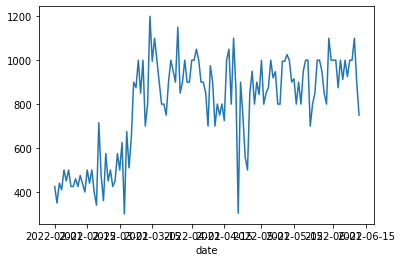

In [30]:
df[df.price < cut_off].groupby("date").price.median().plot()

<AxesSubplot:xlabel='date'>

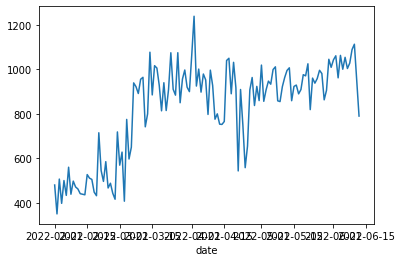

In [31]:
df[df.price < cut_off].groupby("date").price.mean().plot()

In [32]:
price_mean = df[df.price < cut_off].groupby("date").price.mean()
price_min = df[df.price < cut_off].groupby("date").price.min()
price_std = df[df.price < cut_off].groupby("date").price.std()

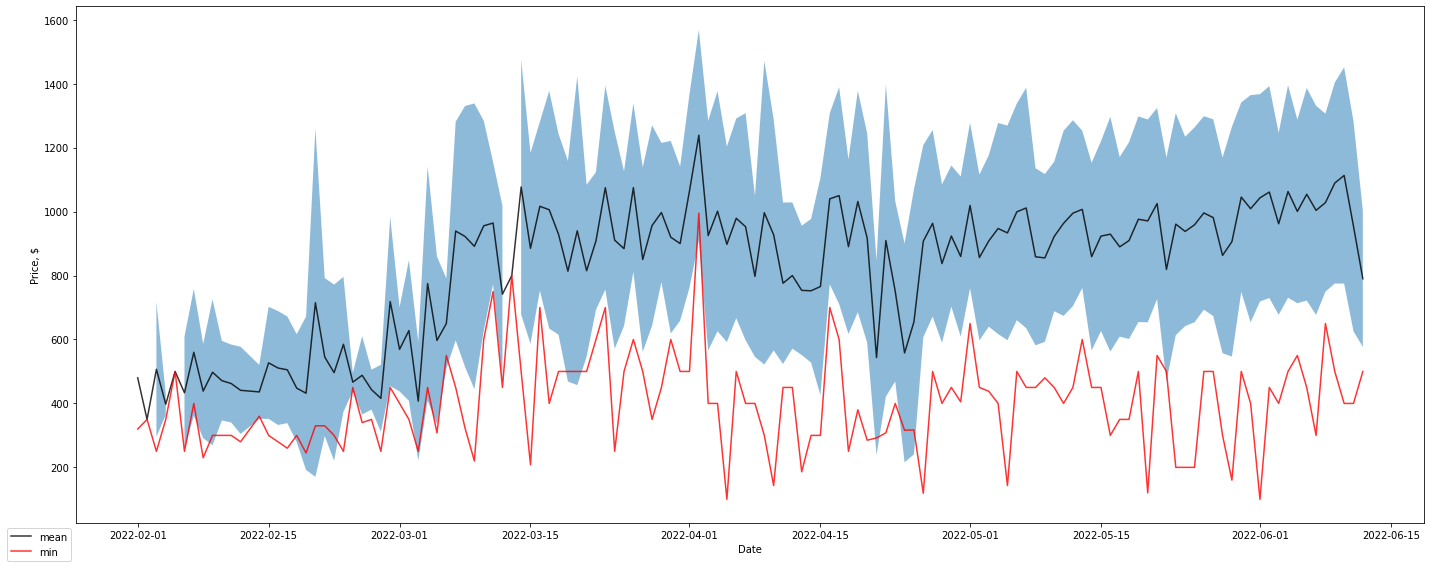

In [35]:
plt.figure(figsize=(20, 8))
plt.rcParams["figure.autolayout"] = True
alpha = 0.8

line1 = plt.plot(price_mean.index, price_mean, alpha=alpha, c="black",label="mean")
line2 = plt.plot(price_mean.index, price_min, alpha=alpha, c="red",label="min")

line3 = plt.fill_between(price_mean.index, price_mean-price_std, price_mean+price_std, alpha = 0.5)

plt.legend(loc=1,bbox_to_anchor=(0,0))
plt.ylabel("Price, $")
plt.xlabel("Date")
plt.show()

In [ ]:
price_min

In [ ]:
price_mean